<a href="https://colab.research.google.com/github/diegofer616/practico01/blob/main/breakout_V0_1_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium
!pip install ale-py
!pip install gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.7 MB/s eta 0:00:00


In [3]:

import gymnasium as gym
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import datetime
from collections import deque
import time
import random
from tqdm import tqdm
from PIL import Image
import cv2
import os
import sys


import tensorflow as tf
from tensorflow import keras
import keras.backend as backend

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

from functools import partial
print= partial(print, flush=True)

In [4]:
# @title Texto de título predeterminado
import ale_py
gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

In [16]:
print('Set parameters')
DEBUG = False
SHOW_EVERY = 200

DISCOUNT = 0.99                 # Discount factor gamma used in the Q-learning update
LEARNING_RATE = 0.00025         # 0.00001   0.00025 Mnih et all 2015
                                  # Hessel et al. 2017 used 0.0000625
                                # in Pong use 0.00025
REPLAY_MEMORY_SIZE = 1000000      #100000  # How many last steps to keep in memory for model training

MIN_REPLAY_MEMORY_SIZE = 50000   #50000  # Minimum number of random steps before to start training with the memory
                                # This is also the Number of completely random actions before the agent starts learning
MAX_FRAMES = 25000000           #50milion # Total number of frames the agent sees during training
MINIBATCH_SIZE = 32             # How many steps (samples) to use for training
UPDATE_TARGET_MODEL =10000       #10000 # Number of chosen actions between updating the target network.

                                       # According to Mnih et al. 2015 this is measured in the number of
                                       # parameter updates (every four actions), however, in the
                                       # DeepMind code, it is clearly measured in the number
                                       # of actions the agent choses
UPDATE_MODEL = 4

MODEL_NAME = 'DQN_DeepMind'
MIN_REWARD = -200  # For model save

#EPISODES = 20000   # number of match played in total during training
EPISODES = 500   # number of match played in total during training

SAVE_EPISODE_EVERY= int(EPISODES/10)#save model 10 times in the whole run


Set parameters


In [6]:
# Exploration annealing settings
epsilon = 1  # not a constant, going to be decayed
MIN_EPSILON = 0.01
MAX_EPSILON = 1.00
MID_EPSILON = 0.1

EPSILON_DECAY_1 = (MAX_EPSILON-MID_EPSILON)/(REPLAY_MEMORY_SIZE-MIN_REPLAY_MEMORY_SIZE)
EPSILON_DECAY_2 = (MID_EPSILON-MIN_EPSILON)/(MAX_FRAMES-REPLAY_MEMORY_SIZE)

#  Stats settings
AGGREGATE_STATS_EVERY = 10  # episodes/match

In [7]:
class DQNAgent():
    def __init__(self):
        # Main model
        self.model = self.create_model()
        print(self.model.summary())

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()

        model.add(Conv2D(32, (8, 8), input_shape=[84, 84, 4], strides=4,
                         kernel_initializer=keras.initializers.VarianceScaling(scale=2.0)))  # 4 frame greyscale 84x84
        model.add(Activation('relu'))
        #model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Conv2D(64, (4, 4), strides=2, kernel_initializer=keras.initializers.VarianceScaling(scale=2.0)))
        model.add(Activation('relu'))
        #model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(64, (3, 3), strides=1, kernel_initializer=keras.initializers.VarianceScaling(scale=2.0)))
        model.add(Activation('relu'))
        #model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(512, kernel_initializer=keras.initializers.VarianceScaling(scale=2.0), activation='relu'))

        model.add(Dense(env.action_space.n, activation='linear',
                        kernel_initializer=keras.initializers.VarianceScaling(scale=2.0)))  # action_space = how many choices (2)
        #model.compile(loss="mse", optimizer=Adam(lr=0.00025), metrics=['accuracy'])
        model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
        return model

    def train(self, minibatch):
        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array(minibatch[0])/255
        current_qs_list = self.model.predict(current_states, verbose=0)

        # Get future states from minibatch, then query NN model for Q values
        new_current_states = np.array(minibatch[3])/255
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)

        X = []
        Y = []

        # Now we need to enumerate our batches
        for ii in range(MINIBATCH_SIZE):
            current_state = minibatch[0][ii]
            action = minibatch[1][ii]
            reward = minibatch[2][ii]
            new_current_state = minibatch[3][ii]
            done = minibatch[4][ii]

            # Bellman equation.  Q = r + gamma*max Q',
            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                new_q = reward + DISCOUNT * np.max(future_qs_list[ii])
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[ii]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            Y.append(current_qs)

        # Fit on all samples as one batch, NO log file saved. Quicker simulation
        # Note : not need to shuffle, this is already done in the get_minibatch part
        self.model.fit(np.array(X), np.array(Y), batch_size=MINIBATCH_SIZE,
                       verbose=0, epochs=1, shuffle=False)

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        self.target_update_counter = 0

    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255, verbose=0)[0]



In [8]:
 # Trains main network every step during episode
def train(self, minibatch):

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array(minibatch[0])/255
        current_qs_list = self.model.predict(current_states,verbose=0)

        # Get future states from minibatch, then query NN model for Q values
        new_current_states = np.array(minibatch[3])/255
        future_qs_list = self.target_model.predict(new_current_states,verbose=0)

        X = []
        Y = []

        # Now we need to enumerate our batches
        for ii in range(MINIBATCH_SIZE):
            current_state     = minibatch[0][ii]
            action            = minibatch[1][ii]
            reward            = minibatch[2][ii]
            new_current_state = minibatch[3][ii]
            done              = minibatch[4][ii]

            # Bellman equation.  Q = r + gamma*max Q',
            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                new_q = reward + DISCOUNT * np.max(future_qs_list[ii])
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[ii]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            Y.append(current_qs)

        # Fit on all samples as one batch, NO log file saved. Quicker simulation
        # Note : not need to shuffle, this is already done in the get_minibatch part
        self.model.fit(np.array(X), np.array(Y), batch_size=MINIBATCH_SIZE,
                       verbose=0, epochs=1,shuffle=False)


In [9]:
# update target model function frames as verified into main (9*)
def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        self.target_update_counter = 0


In [10]:
# Queries main network for Q values given current observation space (environment state)
def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255,verbose=0)[0]

In [11]:
class ReplayMemory(object):  # derived from https://github.com/fg91/Deep-Q-Learning/blob/master/DQN.ipynb
    """Replay Memory that stores the last "size" transitions
    """

    def __init__(self, size=1000, frame_height=84, frame_width=84,
                 agent_history_length=4, batch_size=32):
        """
        Args:
            size: Integer, Number of stored transitions
            frame_height: Integer, Height of a frame of an Atari game
            frame_width: Integer, Width of a frame of an Atari game
            agent_history_length: Integer, Number of frames stacked together to create a state
            batch_size: Integer, Number if transitions returned in a minibatch
        """
        self.size = size
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_history_length = agent_history_length
        self.batch_size = batch_size
        self.count = 0
        self.current = 0
         # Pre-allocate memory
        self.actions = np.empty(self.size, dtype=np.int32)
        self.rewards = np.empty(self.size, dtype=np.float32)
        self.frames = np.empty((self.size, self.frame_height, self.frame_width), dtype=np.uint8)
        self.terminal_flags = np.empty(self.size, dtype=bool)

        # Pre-allocate memory for the states and new_states in a minibatch
        self.states = np.empty((self.batch_size, self.agent_history_length,
                                self.frame_height, self.frame_width), dtype=np.uint8)
        self.new_states = np.empty((self.batch_size, self.agent_history_length,
                                    self.frame_height, self.frame_width), dtype=np.uint8)
        self.indices = np.empty(self.batch_size, dtype=np.int32)

    def add_experience(self, action, frame, reward, terminal):
        """
        Args:
            action: An integer between 0 and env.action_space.n - 1
                determining the action the agent performed  [a_t]
            frame: A (84, 84, 1) frame of an Atari game in grayscale reached due to the action [s_t+1]
            reward: A float determining the reward the agent received for performing an action [r_t]
            terminal: A bool stating whether the episode terminated
        """
        if frame.shape != (self.frame_height, self.frame_width):
            raise ValueError('Dimension of frame is wrong!')
        self.actions[self.current] = action
        self.frames[self.current, ...] = frame
        self.rewards[self.current] = reward
        self.terminal_flags[self.current] = terminal
        self.count = max(self.count, self.current + 1)
        self.current = (self.current + 1) % self.size  # overwrite replay buffer if necessary

    def _get_state(self, index):
        if self.count == 0:
            raise ValueError("The replay memory is empty!")
        if index < self.agent_history_length - 1:
            raise ValueError("Index must be min 3")
        return self.frames[index - self.agent_history_length + 1:index + 1, ...]

    def _get_valid_indices(self):
        """
        We store all frames the agent sees in self.frames.
        When a game terminates (terminal=True) at index i, frame at index i belongs
        to a different episode than the frame at i+1. We want to avoid creating a state
        with frames from two different episodes.
        Finally we need to make sure that an index is not smaller than the number of
        frames stacked together to create a state (self.agent_history_length=4),
        so that a state and new_state can be sliced out of the array.
        """

        for i in range(self.batch_size):
            while True:
                index = random.randint(self.agent_history_length, self.count - 1)
                if index < self.agent_history_length:
                    continue
                if index >= self.current and index - self.agent_history_length <= self.current:
                    continue
                if self.terminal_flags[index - self.agent_history_length:index].any():
                    continue
                break
            self.indices[i] = index

    def get_minibatch(self):
        """
        Returns a minibatch of self.batch_size = 32 transitions
        """
        if self.count < self.agent_history_length:
            raise ValueError('Not enough memories to get a minibatch')

        self._get_valid_indices()

        for i, idx in enumerate(self.indices):
            self.states[i] = self._get_state(idx - 1)
            self.new_states[i] = self._get_state(idx)

        minibatch = (np.transpose(self.states, axes=(0, 2, 3, 1)), self.actions[self.indices], self.rewards[
                     self.indices], np.transpose(self.new_states, axes=(0, 2, 3, 1)), self.terminal_flags[self.indices])
        return minibatch

In [12]:
"""## Pre-processing utility"""

def pre_processing (frame):
    # single Frame Processor from 210x160x3 to 84x84x1
    frame_gray = np.dot(frame, [0.299, 0.587, 0.114])  # 210x160  convert gray scale
    #plt.imshow(np.array(np.squeeze(frame_gray)), cmap='gray')
    #plt.show()
    frame_gray = frame_gray[31:195, 0:160]  # crop off upper score (31 lines) and below black area (15 lines)
    #resized_img0 = Image.fromarray(frame_gray).resize(size=(84, 84), resample=Image.BILINEAR)  # 84x84x1
    resized_img0 = Image.fromarray(frame_gray).resize(size=(84, 84), resample=Image.NEAREST)  # 84x84x1
    #plt.imshow(np.array(np.squeeze(resized_img0)), cmap='gray')
    #plt.show()
    return asarray(resized_img0, dtype=np.uint8)

In [14]:
# Reset environment and get initial state
reset_output = env.reset()

# Handle different possible outputs of env.reset()
if isinstance(reset_output, tuple):
    current_frame = reset_output[0]
else:
    current_frame = reset_output

# Preprocess the current frame
current_frame = pre_processing(current_frame)
current_state = np.dstack((current_frame, current_frame, current_frame, current_frame))  # create imm 84x84 grouping in 4 frames

main training loop


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 20, 20, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686,180 (6.43 MB)

 Trainable params: 1,686,180 (6.43 MB)

 Non-trainable params: 0 (0.00 B)

None
The environment has the following 4 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


  0%|          | 0/500 [00:00<?, ?episodes/s]

main training loop


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 20, 20, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686,180 (6.43 MB)

 Trainable params: 1,686,180 (6.43 MB)

 Non-trainable params: 0 (0.00 B)

None
The environment has the following 4 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']



  4%|3         | 19/500 [00:08<03:00,  2.67episodes/s]

Episode:   20, frame_number:   3602, avg rew: 1.0, max rew: 2.0, min rew: 0.0, current epsilon:0.97142



  6%|5         | 29/500 [00:45<1:10:05,  8.93s/episodes]

Episode:   30, frame_number:   5586, avg rew: 1.6, max rew: 4.0, min rew: 0.0, current epsilon:0.99646



  8%|7         | 39/500 [03:37<2:07:30, 16.60s/episodes]

Episode:   40, frame_number:   7618, avg rew: 1.6, max rew: 3.0, min rew: 0.0, current epsilon:0.97737



 10%|9         | 49/500 [06:18<2:01:35, 16.18s/episodes]

Episode:   50, frame_number:   9347, avg rew: 1.0, max rew: 3.0, min rew: 0.0, current epsilon:0.96042



 12%|#1        | 59/500 [09:12<2:06:09, 17.16s/episodes]

Episode:   60, frame_number:  11289, avg rew: 1.2, max rew: 4.0, min rew: 0.0, current epsilon:0.94262



 14%|#3        | 69/500 [12:16<2:04:26, 17.32s/episodes]

Episode:   70, frame_number:  13211, avg rew: 1.3, max rew: 5.0, min rew: 0.0, current epsilon:0.92355



 16%|#5        | 79/500 [15:23<2:15:23, 19.30s/episodes]

Episode:   80, frame_number:  15218, avg rew: 1.7, max rew: 4.0, min rew: 0.0, current epsilon:0.90449



 18%|#7        | 89/500 [18:02<1:54:08, 16.66s/episodes]

Episode:   90, frame_number:  16901, avg rew: 0.9, max rew: 2.0, min rew: 0.0, current epsilon:0.88850



 20%|#9        | 99/500 [21:07<2:06:20, 18.90s/episodes]

Episode:  100, frame_number:  18912, avg rew: 1.7, max rew: 3.0, min rew: 0.0, current epsilon:0.87011



 22%|##1       | 109/500 [24:40<2:02:53, 18.86s/episodes]

Episode:  110, frame_number:  21038, avg rew: 1.9, max rew: 4.0, min rew: 0.0, current epsilon:0.84936



 24%|##3       | 119/500 [27:50<1:43:29, 16.30s/episodes]

Episode:  120, frame_number:  22979, avg rew: 1.4, max rew: 3.0, min rew: 0.0, current epsilon:0.83136



 26%|##5       | 129/500 [31:03<1:51:34, 18.04s/episodes]

Episode:  130, frame_number:  24977, avg rew: 1.8, max rew: 4.0, min rew: 0.0, current epsilon:0.81266



 28%|##7       | 139/500 [35:01<2:07:53, 21.26s/episodes]

Episode:  140, frame_number:  27230, avg rew: 2.5, max rew: 9.0, min rew: 0.0, current epsilon:0.79059



 30%|##9       | 149/500 [37:51<1:55:41, 19.78s/episodes]

Episode:  150, frame_number:  28887, avg rew: 0.9, max rew: 3.0, min rew: 0.0, current epsilon:0.77501



 32%|###1      | 159/500 [41:39<2:23:48, 25.30s/episodes]

Episode:  160, frame_number:  31112, avg rew: 2.1, max rew: 4.0, min rew: 0.0, current epsilon:0.75432



 34%|###3      | 169/500 [45:12<2:09:21, 23.45s/episodes]

Episode:  170, frame_number:  33047, avg rew: 1.3, max rew: 6.0, min rew: 0.0, current epsilon:0.73585



 36%|###5      | 179/500 [48:56<1:57:25, 21.95s/episodes]

Episode:  180, frame_number:  35117, avg rew: 1.8, max rew: 5.0, min rew: 0.0, current epsilon:0.71624



 38%|###7      | 189/500 [51:58<1:26:34, 16.70s/episodes]

Episode:  190, frame_number:  36722, avg rew: 0.9, max rew: 4.0, min rew: 0.0, current epsilon:0.70068



 40%|###9      | 199/500 [55:19<1:44:45, 20.88s/episodes]

Episode:  200, frame_number:  38695, avg rew: 1.8, max rew: 3.0, min rew: 0.0, current epsilon:0.68318



 42%|####1     | 209/500 [59:36<2:05:23, 25.85s/episodes]

Episode:  210, frame_number:  40969, avg rew: 2.4, max rew: 4.0, min rew: 0.0, current epsilon:0.66150



 44%|####3     | 219/500 [1:03:40<1:46:43, 22.79s/episodes]

Episode:  220, frame_number:  43145, avg rew: 1.9, max rew: 5.0, min rew: 0.0, current epsilon:0.64135



 46%|####5     | 229/500 [1:07:55<1:48:40, 24.06s/episodes]

Episode:  230, frame_number:  45294, avg rew: 2.2, max rew: 4.0, min rew: 0.0, current epsilon:0.62016



 48%|####7     | 239/500 [1:12:19<1:52:26, 25.85s/episodes]

Episode:  240, frame_number:  47565, avg rew: 2.3, max rew: 4.0, min rew: 0.0, current epsilon:0.59881



 50%|####9     | 249/500 [1:17:28<2:38:57, 38.00s/episodes]

Episode:  250, frame_number:  50085, avg rew: 3.1, max rew: 7.0, min rew: 0.0, current epsilon:0.57495



 52%|#####1    | 259/500 [1:21:25<1:35:11, 23.70s/episodes]

Episode:  260, frame_number:  51943, avg rew: 1.3, max rew: 4.0, min rew: 0.0, current epsilon:0.55644



 54%|#####3    | 269/500 [1:25:17<1:34:55, 24.65s/episodes]

Episode:  270, frame_number:  53988, avg rew: 1.8, max rew: 5.0, min rew: 0.0, current epsilon:0.53815



 56%|#####5    | 279/500 [1:29:48<1:36:46, 26.28s/episodes]

Episode:  280, frame_number:  56112, avg rew: 1.9, max rew: 4.0, min rew: 0.0, current epsilon:0.51738



 58%|#####7    | 289/500 [1:34:04<1:18:03, 22.19s/episodes]

Episode:  290, frame_number:  58207, avg rew: 2.2, max rew: 5.0, min rew: 0.0, current epsilon:0.49810



 60%|#####9    | 299/500 [1:38:01<1:22:30, 24.63s/episodes]

Episode:  300, frame_number:  60006, avg rew: 1.3, max rew: 3.0, min rew: 0.0, current epsilon:0.48009



 62%|######1   | 309/500 [1:41:58<1:17:55, 24.48s/episodes]

Episode:  310, frame_number:  61892, avg rew: 1.4, max rew: 5.0, min rew: 0.0, current epsilon:0.46221



 64%|######3   | 319/500 [1:45:41<1:12:21, 23.99s/episodes]

Episode:  320, frame_number:  63758, avg rew: 0.8, max rew: 2.0, min rew: 0.0, current epsilon:0.44582



 66%|######5   | 329/500 [1:50:47<1:29:51, 31.53s/episodes]

Episode:  330, frame_number:  66084, avg rew: 2.0, max rew: 3.0, min rew: 1.0, current epsilon:0.42346



 68%|######7   | 339/500 [1:55:41<1:16:57, 28.68s/episodes]

Episode:  340, frame_number:  68442, avg rew: 2.1, max rew: 4.0, min rew: 0.0, current epsilon:0.40216



 70%|######9   | 349/500 [2:02:35<1:44:09, 41.39s/episodes]

Episode:  350, frame_number:  71483, avg rew: 4.2, max rew: 8.0, min rew: 2.0, current epsilon:0.37365



 72%|#######1  | 359/500 [2:07:37<1:02:12, 26.47s/episodes]

Episode:  360, frame_number:  73611, avg rew: 2.1, max rew: 5.0, min rew: 0.0, current epsilon:0.35258



 74%|#######3  | 369/500 [2:13:10<1:24:03, 38.50s/episodes]

Episode:  370, frame_number:  76126, avg rew: 2.7, max rew: 4.0, min rew: 0.0, current epsilon:0.32947



 76%|#######5  | 379/500 [2:18:29<1:02:24, 30.95s/episodes]

Episode:  380, frame_number:  78349, avg rew: 2.2, max rew: 4.0, min rew: 0.0, current epsilon:0.30792



 78%|#######7  | 389/500 [2:25:25<1:16:39, 41.43s/episodes]

Episode:  390, frame_number:  81387, avg rew: 3.0, max rew: 5.0, min rew: 0.0, current epsilon:0.28002



 80%|#######9  | 399/500 [2:32:09<54:29, 32.37s/episodes]

Episode:  400, frame_number:  84067, avg rew: 3.1, max rew: 6.0, min rew: 1.0, current epsilon:0.25279



 82%|########1 | 409/500 [2:36:56<49:33, 32.68s/episodes]

Episode:  410, frame_number:  86212, avg rew: 1.8, max rew: 4.0, min rew: 0.0, current epsilon:0.23362



 84%|########3 | 419/500 [2:43:11<46:53, 34.74s/episodes]

Episode:  420, frame_number:  88639, avg rew: 2.2, max rew: 6.0, min rew: 0.0, current epsilon:0.20881



 86%|########5 | 429/500 [2:50:27<54:49, 46.33s/episodes]

Episode:  430, frame_number:  91845, avg rew: 3.5, max rew: 5.0, min rew: 1.0, current epsilon:0.18060



 88%|########7 | 439/500 [2:59:01<53:22, 52.50s/episodes]

Episode:  440, frame_number:  95178, avg rew: 3.3, max rew: 5.0, min rew: 2.0, current epsilon:0.15049



 90%|########9 | 449/500 [3:06:44<44:21, 52.19s/episodes]

Episode:  450, frame_number:  98083, avg rew: 1.4, max rew: 4.0, min rew: 0.0, current epsilon:0.12170



 92%|#########1| 459/500 [3:16:20<40:45, 59.64s/episodes]

Episode:  460, frame_number: 101833, avg rew: 2.6, max rew: 4.0, min rew: 1.0, current epsilon:0.10000



 94%|#########3| 469/500 [3:24:04<17:22, 33.64s/episodes]

Episode:  470, frame_number: 104397, avg rew: 2.4, max rew: 4.0, min rew: 0.0, current epsilon:0.09998



 96%|#########5| 479/500 [3:31:10<19:11, 54.85s/episodes]

Episode:  480, frame_number: 107451, avg rew: 2.3, max rew: 4.0, min rew: 0.0, current epsilon:0.09997



 98%|#########7| 489/500 [3:40:33<08:54, 48.62s/episodes]

Episode:  490, frame_number: 110917, avg rew: 2.4, max rew: 5.0, min rew: 0.0, current epsilon:0.09996



100%|#########9| 499/500 [3:48:15<00:54, 54.31s/episodes]

Episode:  500, frame_number: 114121, avg rew: 2.1, max rew: 5.0, min rew: 0.0, current epsilon:0.09995



100%|##########| 500/500 [3:49:39<00:00, 27.56s/episodes]


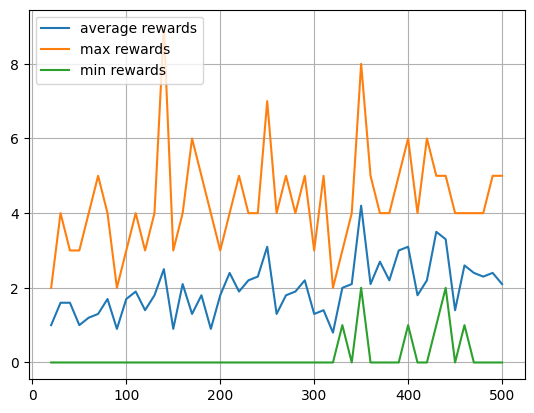

  0%|          | 1/500 [3:49:40<1910:06:26, 13780.33s/episodes]

main training loop


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 20, 20, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686,180 (6.43 MB)

 Trainable params: 1,686,180 (6.43 MB)

 Non-trainable params: 0 (0.00 B)

None
The environment has the following 4 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']



  4%|3         | 19/500 [00:09<05:33,  1.44episodes/s]

Episode:   20, frame_number:   3968, avg rew: 1.6, max rew: 4.0, min rew: 0.0, current epsilon:0.09995



  6%|5         | 29/500 [01:52<2:38:58, 20.25s/episodes]

Episode:   30, frame_number:   6198, avg rew: 2.1, max rew: 5.0, min rew: 0.0, current epsilon:0.99048



  8%|7         | 39/500 [04:34<2:00:00, 15.62s/episodes]

Episode:   40, frame_number:   7982, avg rew: 1.0, max rew: 4.0, min rew: 0.0, current epsilon:0.97308



 10%|9         | 49/500 [07:20<2:01:24, 16.15s/episodes]

Episode:   50, frame_number:   9841, avg rew: 1.3, max rew: 6.0, min rew: 0.0, current epsilon:0.95564



 12%|#1        | 59/500 [10:06<2:15:55, 18.49s/episodes]

Episode:   60, frame_number:  11588, avg rew: 1.2, max rew: 3.0, min rew: 0.0, current epsilon:0.93883



 14%|#3        | 69/500 [12:56<2:04:40, 17.36s/episodes]

Episode:   70, frame_number:  13462, avg rew: 1.4, max rew: 5.0, min rew: 0.0, current epsilon:0.92133



 16%|#5        | 79/500 [15:32<1:57:00, 16.68s/episodes]

Episode:   80, frame_number:  15275, avg rew: 1.4, max rew: 5.0, min rew: 0.0, current epsilon:0.90559



 18%|#7        | 89/500 [19:02<2:17:08, 20.02s/episodes]

Episode:   90, frame_number:  17315, avg rew: 1.8, max rew: 5.0, min rew: 0.0, current epsilon:0.88484



 20%|#9        | 99/500 [21:50<1:51:16, 16.65s/episodes]

Episode:  100, frame_number:  19088, avg rew: 1.1, max rew: 2.0, min rew: 0.0, current epsilon:0.86831



 22%|##1       | 109/500 [25:07<2:16:41, 20.98s/episodes]

Episode:  110, frame_number:  21102, avg rew: 1.7, max rew: 4.0, min rew: 0.0, current epsilon:0.84911



 24%|##3       | 119/500 [27:42<1:46:07, 16.71s/episodes]

Episode:  120, frame_number:  22629, avg rew: 0.6, max rew: 2.0, min rew: 0.0, current epsilon:0.83460



 26%|##5       | 129/500 [30:56<2:03:40, 20.00s/episodes]

Episode:  130, frame_number:  24749, avg rew: 1.9, max rew: 5.0, min rew: 0.0, current epsilon:0.81621



 28%|##7       | 139/500 [34:18<1:45:16, 17.50s/episodes]

Episode:  140, frame_number:  26571, avg rew: 1.3, max rew: 3.0, min rew: 0.0, current epsilon:0.79748



 30%|##9       | 149/500 [38:02<2:06:42, 21.66s/episodes]

Episode:  150, frame_number:  28719, avg rew: 1.8, max rew: 5.0, min rew: 0.0, current epsilon:0.77665



 32%|###1      | 159/500 [41:40<2:01:22, 21.36s/episodes]

Episode:  160, frame_number:  30893, avg rew: 2.3, max rew: 6.0, min rew: 0.0, current epsilon:0.75658



 34%|###3      | 169/500 [45:03<1:57:20, 21.27s/episodes]

Episode:  170, frame_number:  32793, avg rew: 1.3, max rew: 3.0, min rew: 0.0, current epsilon:0.73845



 36%|###5      | 179/500 [48:57<2:06:16, 23.60s/episodes]

Episode:  180, frame_number:  35028, avg rew: 2.3, max rew: 3.0, min rew: 1.0, current epsilon:0.71789



 38%|###7      | 189/500 [53:16<2:19:18, 26.87s/episodes]

Episode:  190, frame_number:  37396, avg rew: 2.6, max rew: 4.0, min rew: 1.0, current epsilon:0.69528



 40%|###9      | 199/500 [57:04<2:18:19, 27.57s/episodes]

Episode:  200, frame_number:  39525, avg rew: 2.0, max rew: 6.0, min rew: 0.0, current epsilon:0.67529



 42%|####1     | 209/500 [1:01:16<1:57:27, 24.22s/episodes]

Episode:  210, frame_number:  41676, avg rew: 2.3, max rew: 7.0, min rew: 0.0, current epsilon:0.65447



 44%|####3     | 219/500 [1:05:25<1:50:37, 23.62s/episodes]

Episode:  220, frame_number:  43827, avg rew: 1.9, max rew: 4.0, min rew: 0.0, current epsilon:0.63370



 46%|####5     | 229/500 [1:09:30<1:58:15, 26.18s/episodes]

Episode:  230, frame_number:  46279, avg rew: 2.3, max rew: 9.0, min rew: 0.0, current epsilon:0.61382



 48%|####7     | 239/500 [1:14:35<2:04:28, 28.61s/episodes]

Episode:  240, frame_number:  48588, avg rew: 2.8, max rew: 5.0, min rew: 0.0, current epsilon:0.58918



 50%|####9     | 249/500 [1:19:09<2:18:19, 33.07s/episodes]

Episode:  250, frame_number:  50903, avg rew: 2.6, max rew: 7.0, min rew: 0.0, current epsilon:0.56755



 52%|#####1    | 259/500 [1:23:10<1:34:06, 23.43s/episodes]

Episode:  260, frame_number:  53045, avg rew: 1.8, max rew: 7.0, min rew: 0.0, current epsilon:0.54863



 54%|#####3    | 269/500 [1:28:41<2:02:06, 31.72s/episodes]

Episode:  270, frame_number:  55523, avg rew: 2.7, max rew: 5.0, min rew: 1.0, current epsilon:0.52309



 56%|#####5    | 279/500 [1:33:32<1:41:09, 27.46s/episodes]

Episode:  280, frame_number:  57821, avg rew: 2.1, max rew: 5.0, min rew: 0.0, current epsilon:0.50141



 58%|#####7    | 289/500 [1:37:26<1:25:17, 24.25s/episodes]

Episode:  290, frame_number:  59764, avg rew: 1.2, max rew: 4.0, min rew: 0.0, current epsilon:0.48395



 60%|#####9    | 299/500 [1:42:45<1:58:53, 35.49s/episodes]

Episode:  300, frame_number:  62139, avg rew: 2.4, max rew: 6.0, min rew: 1.0, current epsilon:0.46061



 62%|######1   | 309/500 [1:47:47<1:54:54, 36.10s/episodes]

Episode:  310, frame_number:  64533, avg rew: 2.4, max rew: 6.0, min rew: 0.0, current epsilon:0.43885



 64%|######3   | 319/500 [1:52:40<1:41:21, 33.60s/episodes]

Episode:  320, frame_number:  66663, avg rew: 1.4, max rew: 4.0, min rew: 0.0, current epsilon:0.41788



 66%|######5   | 329/500 [1:58:07<1:42:23, 35.93s/episodes]

Episode:  330, frame_number:  69124, avg rew: 2.5, max rew: 5.0, min rew: 0.0, current epsilon:0.39465



 68%|######7   | 339/500 [2:04:09<1:41:07, 37.68s/episodes]

Episode:  340, frame_number:  71840, avg rew: 3.1, max rew: 6.0, min rew: 0.0, current epsilon:0.36923



 70%|######9   | 349/500 [2:10:30<1:50:29, 43.90s/episodes]

Episode:  350, frame_number:  74586, avg rew: 3.1, max rew: 6.0, min rew: 0.0, current epsilon:0.34306



 72%|#######1  | 359/500 [2:16:50<1:35:21, 40.58s/episodes]

Episode:  360, frame_number:  77318, avg rew: 2.9, max rew: 6.0, min rew: 1.0, current epsilon:0.31727



 74%|#######3  | 369/500 [2:21:49<1:20:38, 36.94s/episodes]

Episode:  370, frame_number:  79450, avg rew: 1.9, max rew: 4.0, min rew: 0.0, current epsilon:0.29731



 76%|#######5  | 379/500 [2:27:17<1:02:03, 30.78s/episodes]

Episode:  380, frame_number:  81658, avg rew: 2.0, max rew: 4.0, min rew: 0.0, current epsilon:0.27570



 78%|#######7  | 389/500 [2:33:52<1:16:35, 41.40s/episodes]

Episode:  390, frame_number:  84431, avg rew: 3.3, max rew: 5.0, min rew: 1.0, current epsilon:0.25021



 80%|#######9  | 399/500 [2:41:51<1:15:24, 44.80s/episodes]

Episode:  400, frame_number:  87505, avg rew: 3.8, max rew: 6.0, min rew: 0.0, current epsilon:0.21953



 82%|########1 | 409/500 [2:48:43<1:20:38, 53.18s/episodes]

Episode:  410, frame_number:  90567, avg rew: 2.3, max rew: 9.0, min rew: 0.0, current epsilon:0.19372



 84%|########3 | 419/500 [2:57:23<1:07:18, 49.86s/episodes]

Episode:  420, frame_number:  93937, avg rew: 3.5, max rew: 5.0, min rew: 1.0, current epsilon:0.16107



 86%|########5 | 429/500 [3:06:40<1:06:50, 56.49s/episodes]

Episode:  430, frame_number:  97370, avg rew: 3.5, max rew: 5.0, min rew: 1.0, current epsilon:0.12713



 88%|########7 | 439/500 [3:14:24<57:41, 56.74s/episodes]

Episode:  440, frame_number: 100551, avg rew: 2.3, max rew: 5.0, min rew: 0.0, current epsilon:0.10000



 90%|########9 | 449/500 [3:23:26<38:33, 45.37s/episodes]

Episode:  450, frame_number: 104199, avg rew: 3.0, max rew: 4.0, min rew: 1.0, current epsilon:0.09999



 92%|#########1| 459/500 [3:34:04<42:13, 61.79s/episodes]

Episode:  460, frame_number: 107954, avg rew: 2.3, max rew: 5.0, min rew: 0.0, current epsilon:0.09997



 94%|#########3| 469/500 [3:45:02<30:48, 59.61s/episodes]

Episode:  470, frame_number: 112050, avg rew: 3.3, max rew: 6.0, min rew: 1.0, current epsilon:0.09996



 96%|#########5| 479/500 [3:52:18<18:47, 53.68s/episodes]

Episode:  480, frame_number: 114871, avg rew: 2.1, max rew: 4.0, min rew: 0.0, current epsilon:0.09995



 98%|#########7| 489/500 [4:02:22<11:52, 64.74s/episodes]

Episode:  490, frame_number: 118766, avg rew: 2.9, max rew: 5.0, min rew: 0.0, current epsilon:0.09993



100%|#########9| 499/500 [4:10:24<01:01, 61.38s/episodes]

Episode:  500, frame_number: 121849, avg rew: 2.1, max rew: 5.0, min rew: 1.0, current epsilon:0.09992



100%|##########| 500/500 [4:11:23<00:00, 30.17s/episodes]


<Figure size 640x480 with 0 Axes>

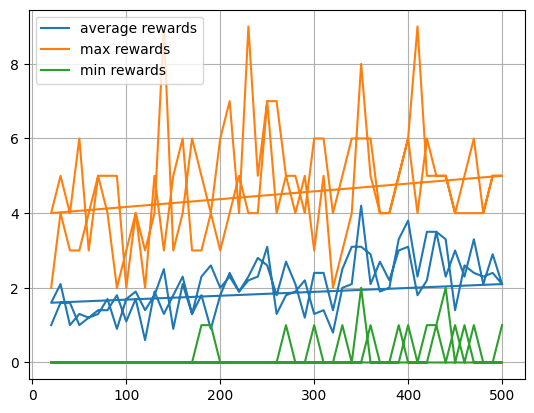

  0%|          | 2/500 [8:01:05<2012:25:49, 14547.69s/episodes]

main training loop


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 20, 20, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_37 (Activation)           │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_38 (Activation)           │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686,180 (6.43 MB)

 Trainable params: 1,686,180 (6.43 MB)

 Non-trainable params: 0 (0.00 B)

None
The environment has the following 4 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']



  4%|3         | 19/500 [00:07<04:19,  1.86episodes/s]

Episode:   20, frame_number:   3424, avg rew: 1.0, max rew: 3.0, min rew: 0.0, current epsilon:0.09992



  6%|5         | 29/500 [01:08<1:48:10, 13.78s/episodes]

Episode:   30, frame_number:   5572, avg rew: 1.7, max rew: 4.0, min rew: 0.0, current epsilon:0.99584



  8%|7         | 39/500 [03:44<2:05:33, 16.34s/episodes]

Episode:   40, frame_number:   7319, avg rew: 1.0, max rew: 3.0, min rew: 0.0, current epsilon:0.97950



 10%|9         | 49/500 [06:46<2:28:39, 19.78s/episodes]

Episode:   50, frame_number:   9236, avg rew: 1.3, max rew: 3.0, min rew: 0.0, current epsilon:0.96116



 12%|#1        | 59/500 [09:41<2:33:26, 20.88s/episodes]

Episode:   60, frame_number:  11195, avg rew: 1.5, max rew: 5.0, min rew: 0.0, current epsilon:0.94333



 14%|#3        | 69/500 [12:15<1:49:21, 15.22s/episodes]

Episode:   70, frame_number:  12752, avg rew: 0.6, max rew: 2.0, min rew: 0.0, current epsilon:0.92780



 16%|#5        | 79/500 [15:27<2:05:36, 17.90s/episodes]

Episode:   80, frame_number:  14809, avg rew: 1.9, max rew: 4.0, min rew: 0.0, current epsilon:0.90865



 18%|#7        | 89/500 [18:16<1:49:39, 16.01s/episodes]

Episode:   90, frame_number:  16590, avg rew: 1.1, max rew: 4.0, min rew: 0.0, current epsilon:0.89215



 20%|#9        | 99/500 [21:38<2:08:51, 19.28s/episodes]

Episode:  100, frame_number:  18633, avg rew: 1.9, max rew: 5.0, min rew: 0.0, current epsilon:0.87301



 22%|##1       | 109/500 [24:47<1:58:13, 18.14s/episodes]

Episode:  110, frame_number:  20534, avg rew: 1.5, max rew: 3.0, min rew: 0.0, current epsilon:0.85501



 24%|##3       | 119/500 [27:58<2:04:08, 19.55s/episodes]

Episode:  120, frame_number:  22368, avg rew: 1.1, max rew: 3.0, min rew: 0.0, current epsilon:0.83671



 26%|##5       | 129/500 [31:31<2:24:29, 23.37s/episodes]

Episode:  130, frame_number:  24444, avg rew: 1.8, max rew: 4.0, min rew: 0.0, current epsilon:0.81704



 28%|##7       | 139/500 [34:21<1:46:00, 17.62s/episodes]

Episode:  140, frame_number:  26188, avg rew: 1.1, max rew: 4.0, min rew: 0.0, current epsilon:0.80121



 30%|##9       | 149/500 [38:24<1:56:51, 19.97s/episodes]

Episode:  150, frame_number:  28468, avg rew: 2.1, max rew: 5.0, min rew: 0.0, current epsilon:0.77912



 32%|###1      | 159/500 [42:00<2:04:42, 21.94s/episodes]

Episode:  160, frame_number:  30561, avg rew: 1.8, max rew: 6.0, min rew: 0.0, current epsilon:0.75994



 34%|###3      | 169/500 [46:08<2:08:53, 23.36s/episodes]

Episode:  170, frame_number:  32764, avg rew: 2.1, max rew: 3.0, min rew: 0.0, current epsilon:0.73814



 36%|###5      | 179/500 [49:25<2:02:40, 22.93s/episodes]

Episode:  180, frame_number:  34674, avg rew: 1.3, max rew: 5.0, min rew: 0.0, current epsilon:0.72092



 38%|###7      | 189/500 [53:48<1:58:30, 22.86s/episodes]

Episode:  190, frame_number:  37229, avg rew: 2.9, max rew: 7.0, min rew: 0.0, current epsilon:0.69850



 40%|###9      | 199/500 [58:12<2:00:54, 24.10s/episodes]

Episode:  200, frame_number:  39403, avg rew: 1.9, max rew: 4.0, min rew: 0.0, current epsilon:0.67626



 42%|####1     | 209/500 [1:01:53<1:35:23, 19.67s/episodes]

Episode:  210, frame_number:  41275, avg rew: 1.2, max rew: 3.0, min rew: 0.0, current epsilon:0.65779



 44%|####3     | 219/500 [1:05:41<1:35:42, 20.44s/episodes]

Episode:  220, frame_number:  43392, avg rew: 1.7, max rew: 3.0, min rew: 0.0, current epsilon:0.63891



 46%|####5     | 229/500 [1:09:25<1:34:37, 20.95s/episodes]

Episode:  230, frame_number:  45211, avg rew: 1.4, max rew: 3.0, min rew: 0.0, current epsilon:0.62060



 48%|####7     | 239/500 [1:12:58<1:23:14, 19.14s/episodes]

Episode:  240, frame_number:  47222, avg rew: 1.5, max rew: 5.0, min rew: 0.0, current epsilon:0.60316



 50%|####9     | 249/500 [1:17:36<1:54:10, 27.29s/episodes]

Episode:  250, frame_number:  49411, avg rew: 1.5, max rew: 4.0, min rew: 0.0, current epsilon:0.58104



 52%|#####1    | 259/500 [1:21:48<1:49:19, 27.22s/episodes]

Episode:  260, frame_number:  51565, avg rew: 1.8, max rew: 6.0, min rew: 0.0, current epsilon:0.56119



 54%|#####3    | 269/500 [1:25:55<1:43:14, 26.82s/episodes]

Episode:  270, frame_number:  53675, avg rew: 1.6, max rew: 4.0, min rew: 0.0, current epsilon:0.54155



 56%|#####5    | 279/500 [1:30:30<1:39:40, 27.06s/episodes]

Episode:  280, frame_number:  55775, avg rew: 1.5, max rew: 3.0, min rew: 0.0, current epsilon:0.52068



 58%|#####7    | 289/500 [1:34:45<1:19:08, 22.51s/episodes]

Episode:  290, frame_number:  57798, avg rew: 1.3, max rew: 5.0, min rew: 0.0, current epsilon:0.50131



 60%|#####9    | 299/500 [1:38:44<1:26:18, 25.76s/episodes]

Episode:  300, frame_number:  59657, avg rew: 1.0, max rew: 4.0, min rew: 0.0, current epsilon:0.48364



 62%|######1   | 309/500 [1:42:42<1:23:03, 26.09s/episodes]

Episode:  310, frame_number:  61660, avg rew: 1.5, max rew: 4.0, min rew: 0.0, current epsilon:0.46603



 64%|######3   | 319/500 [1:48:06<1:30:03, 29.85s/episodes]

Episode:  320, frame_number:  64114, avg rew: 2.7, max rew: 5.0, min rew: 0.0, current epsilon:0.44237



 66%|######5   | 329/500 [1:54:41<1:51:58, 39.29s/episodes]

Episode:  330, frame_number:  67120, avg rew: 3.7, max rew: 7.0, min rew: 2.0, current epsilon:0.41350



 68%|######7   | 339/500 [1:59:00<1:11:52, 26.79s/episodes]

Episode:  340, frame_number:  69011, avg rew: 1.0, max rew: 5.0, min rew: 0.0, current epsilon:0.39495



 70%|######9   | 349/500 [2:03:23<1:11:15, 28.31s/episodes]

Episode:  350, frame_number:  71111, avg rew: 1.3, max rew: 3.0, min rew: 0.0, current epsilon:0.37587



 72%|#######1  | 359/500 [2:08:46<1:17:12, 32.85s/episodes]

Episode:  360, frame_number:  73555, avg rew: 1.8, max rew: 4.0, min rew: 0.0, current epsilon:0.35307



 74%|#######3  | 369/500 [2:13:26<52:19, 23.97s/episodes]  

Episode:  370, frame_number:  75548, avg rew: 1.6, max rew: 4.0, min rew: 0.0, current epsilon:0.33330



 76%|#######5  | 379/500 [2:17:58<53:33, 26.55s/episodes]  

Episode:  380, frame_number:  77513, avg rew: 1.1, max rew: 3.0, min rew: 0.0, current epsilon:0.31446



 78%|#######7  | 389/500 [2:23:45<1:11:19, 38.55s/episodes]

Episode:  390, frame_number:  80205, avg rew: 2.4, max rew: 5.0, min rew: 0.0, current epsilon:0.29025



 80%|#######9  | 399/500 [2:29:18<51:37, 30.67s/episodes]

Episode:  400, frame_number:  82651, avg rew: 2.3, max rew: 5.0, min rew: 0.0, current epsilon:0.26760



 82%|########1 | 409/500 [2:35:13<54:44, 36.09s/episodes]

Episode:  410, frame_number:  85142, avg rew: 2.5, max rew: 6.0, min rew: 0.0, current epsilon:0.24394



 84%|########3 | 419/500 [2:42:02<53:02, 39.29s/episodes]

Episode:  420, frame_number:  87971, avg rew: 2.6, max rew: 5.0, min rew: 0.0, current epsilon:0.21684



 86%|########5 | 429/500 [2:48:06<37:35, 31.77s/episodes]

Episode:  430, frame_number:  90379, avg rew: 1.5, max rew: 5.0, min rew: 0.0, current epsilon:0.19288



 88%|########7 | 439/500 [2:56:12<54:07, 53.23s/episodes]

Episode:  440, frame_number:  93832, avg rew: 3.6, max rew: 7.0, min rew: 1.0, current epsilon:0.16146



 90%|########9 | 449/500 [3:04:20<45:21, 53.36s/episodes]

Episode:  450, frame_number:  96891, avg rew: 2.1, max rew: 5.0, min rew: 0.0, current epsilon:0.13108



 92%|#########1| 459/500 [3:12:35<33:50, 49.52s/episodes]

Episode:  460, frame_number: 100402, avg rew: 1.9, max rew: 4.0, min rew: 0.0, current epsilon:0.10065



 93%|#########3| 465/500 [3:18:22<36:31, 62.62s/episodes]

In [ ]:
"""## Main training loop"""

aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
print('main training loop')
# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')

agent = DQNAgent()
print("The environment has the following {} actions: {}".format(env.action_space.n,
                                                                env.unwrapped.get_action_meanings()))


my_replay_memory = ReplayMemory(size=REPLAY_MEMORY_SIZE, batch_size=MINIBATCH_SIZE)   # (â˜…)
frame_number = 0   # total number of step conducted from the first match till the last
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):  #1 episode = 1 match

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
#    current_frame,_ = env.reset()   # single frame 84x84
    #NEW VERSION : take care, the new format of the result is a tuple ...
    current_frame,_ = env.reset()   # single frame 84x84

    current_frame = pre_processing(current_frame)
    current_state = np.dstack((current_frame, current_frame, current_frame, current_frame)) # create imm 84x84 grouping in 4 frames

    # Reset flag and start iterating until episode ends
    done = False
    while not done:   #in the environment MountainCar-v0 done=False after 200 step
                      #in the environment Breakout-v4 done=False after lost all lifes (num life =5)
        # Exploration-exploitation trade-off
        # Take new action
        # train main network
        # Set new state
        # Add new reward

        # Exploration-exploitation trade-off after a number of steps with completely random action
        if np.random.random() > epsilon and frame_number > MIN_REPLAY_MEMORY_SIZE:
            # Get action from DQN model: exploit
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action: explore
            action = np.random.randint(0, env.action_space.n)

        # Take new action
#        new_frame, reward, done, _ = env.step(action)
        #new format
        new_frame, reward, done1,done2, _ = env.step(action)
        done = done1 |done2
        reward = np.clip(reward,-1,1)#clip reward to be between -1,1
        # Set and preprocess new state
        new_frame = pre_processing(new_frame)  # single frame 84x84 preprocessed
        new_state = np.dstack((new_frame, current_state[:, :, 0], current_state[:, :, 1], current_state[:, :, 2]))# create imm 84x84 grouping in 4 frames

        episode_reward += reward

        if episode % SHOW_EVERY == 0: # and DEBUG: # plot one match every SHOW_EVERY
            #time.sleep(0.01)
            #print(f'Step: {step}')
            env.render()

        # Every step/frame we update replay memory with action, new frame, reward due to the action
        my_replay_memory.add_experience(action, new_frame, reward, done)

        # Every step we evaluate to train main network and/or to update weights of target network
        if frame_number % UPDATE_MODEL == 0 and frame_number > MIN_REPLAY_MEMORY_SIZE:  # model update every 4 frame/action
            # Get a minibatch of random samples from the replay memory
            minibatch = my_replay_memory.get_minibatch()
            agent.train(minibatch)                  #
            if DEBUG:  # plot of the minibatch used to train (only 1 image over 4 into the frame)
                fig = plt.figure(figsize=(8*4, 4*4))
                for i in range(my_replay_memory.batch_size):
                    plt.subplot(4, 8, i + 1)
                    plt.imshow(minibatch[0][i, :, :, 0], cmap='jet')
                plt.show()
                plt.savefig('minibatch'+str(frame_number)+'.jpg')
            del minibatch
        if frame_number % UPDATE_TARGET_MODEL == 0 and frame_number > MIN_REPLAY_MEMORY_SIZE: # model target update every 10000 frame/action
            agent.update_target_model()    # (9â˜…)
        #


        # Set new state (9*)
        current_state = new_state
        step += 1
        frame_number += 1

                # Inicializa ep_rewards como una lista vacía
        ep_rewards = []

                # Main training loop
        print('main training loop')
        # Create models folder
        if not os.path.isdir('models'):
            os.makedirs('models')

        agent = DQNAgent()
        print("The environment has the following {} actions: {}".format(env.action_space.n,
                                                                        env.unwrapped.get_action_meanings()))

        my_replay_memory = ReplayMemory(size=REPLAY_MEMORY_SIZE, batch_size=MINIBATCH_SIZE)   # (★)
        frame_number = 0   # total number of step conducted from the first match till the last
        # Inicializa ep_rewards como una lista vacía
        ep_rewards = []

        # Iterate over episodes
        for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):  #1 episode = 1 match

            # Restarting episode - reset episode reward and step number
            episode_reward = 0
            step = 1

            # Reset environment and get initial state
            reset_output = env.reset()

            # Handle different possible outputs of env.reset()
            if isinstance(reset_output, tuple):
                current_frame = reset_output[0]
            else:
                current_frame = reset_output

            # Preprocess the current frame
            current_frame = pre_processing(current_frame)
            current_state = np.dstack((current_frame, current_frame, current_frame, current_frame))  # create imm 84x84 grouping in 4 frames

            # Reset flag and start iterating until episode ends
            done = False
            while not done:   #in the environment MountainCar-v0 done=False after 200 step
                              #in the environment Breakout-v4 done=False after lost all lifes (num life =5)
                # Exploration-exploitation trade-off
                # Take new action
                # train main network
                # Set new state
                # Add new reward

                # Exploration-exploitation trade-off after a number of steps with completely random action
                if np.random.random() > epsilon and frame_number > MIN_REPLAY_MEMORY_SIZE:
                    # Get action from DQN model: exploit
                    action = np.argmax(agent.get_qs(current_state))
                else:
                    # Get random action: explore
                    action = np.random.randint(0, env.action_space.n)

                # Take new action
                new_frame, reward, done1, done2, _ = env.step(action)
                done = done1 | done2
                reward = np.clip(reward, -1, 1)  # clip reward to be between -1,1
                # Set and preprocess new state
                new_frame = pre_processing(new_frame)  # single frame 84x84 preprocessed
                new_state = np.dstack((new_frame, current_state[:, :, 0], current_state[:, :, 1], current_state[:, :, 2]))  # create imm 84x84 grouping in 4 frames

                episode_reward += reward

                if episode % SHOW_EVERY == 0:  # and DEBUG: # plot one match every SHOW_EVERY
                    env.render()

                # Every step/frame we update replay memory with action, new frame, reward due to the action
                my_replay_memory.add_experience(action, new_frame, reward, done)

                # Every step we evaluate to train main network and/or to update weights of target network
                if frame_number % UPDATE_MODEL == 0 and frame_number > MIN_REPLAY_MEMORY_SIZE:  # model update every 4 frame/action
                    # Get a minibatch of random samples from the replay memory
                    minibatch = my_replay_memory.get_minibatch()
                    agent.train(minibatch)
                    if DEBUG:  # plot of the minibatch used to train (only 1 image over 4 into the frame)
                        fig = plt.figure(figsize=(8*4, 4*4))
                        for i in range(my_replay_memory.batch_size):
                            plt.subplot(4, 8, i + 1)
                            plt.imshow(minibatch[0][i, :, :, 0], cmap='jet')
                        plt.show()
                        plt.savefig('minibatch'+str(frame_number)+'.jpg')
                    del minibatch
                if frame_number % UPDATE_TARGET_MODEL == 0 and frame_number > MIN_REPLAY_MEMORY_SIZE:  # model target update every 10000 frame/action
                    agent.update_target_model()

                # Set new state
                current_state = new_state
                step += 1
                frame_number += 1

                        # Append episode reward to a list and log stats (every given number of episodes)
            ep_rewards.append(episode_reward)
            if episode % 10 == 0 and episode > AGGREGATE_STATS_EVERY:
                average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:]) / len(ep_rewards[-AGGREGATE_STATS_EVERY:])
                min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
                max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
                aggr_ep_rewards['ep'].append(episode)
                aggr_ep_rewards['avg'].append(average_reward)
                aggr_ep_rewards['max'].append(max_reward)
                aggr_ep_rewards['min'].append(min_reward)
                print(f'Episode:{episode:>5d}, frame_number:{frame_number:>7d}, ' +
                      f'avg rew:{average_reward:>4.1f}, ' +
                      f'max rew:{max(ep_rewards[-AGGREGATE_STATS_EVERY:]):>4.1f}, ' +
                      f'min rew:{min(ep_rewards[-AGGREGATE_STATS_EVERY:]):>4.1f}, ' +
                      f'current epsilon:{epsilon:>1.5f}')

            # Decay epsilon. Only start after replay memory is over min size
            if frame_number > MIN_REPLAY_MEMORY_SIZE:
                if frame_number < REPLAY_MEMORY_SIZE:
                    epsilon = MID_EPSILON + EPSILON_DECAY_1*(REPLAY_MEMORY_SIZE-frame_number)
                else:
                    epsilon = MIN_EPSILON + EPSILON_DECAY_2*(MAX_FRAMES-frame_number)
            epsilon = np.clip(epsilon, MIN_EPSILON, MAX_EPSILON)

            if episode % SAVE_EPISODE_EVERY == 0 and episode > AGGREGATE_STATS_EVERY:
                agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}' +
                                 f'max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}' +
                                 f'min__{int(time.time())}.keras')

        env.close()
        # Save model
        agent.model.save(f'models/{MODEL_NAME}__' +
                         f'{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_' +
                         f'{min_reward:_>7.2f}min__{int(time.time())}.keras')

        plt.figure('stats')
        plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
        plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
        plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
        plt.legend(loc=2)
        plt.grid(True)
        plt.show()
        plt.savefig('grid.jpg')

debug and test results
play game and draw results
best action= NOOP frame= 1
best action= NOOP frame= 2
best action= NOOP frame= 3
best action= NOOP frame= 4
best action= NOOP frame= 5
best action= NOOP frame= 6
best action= NOOP frame= 7
best action= NOOP frame= 8
best action= NOOP frame= 9
best action= NOOP frame= 10
best action= NOOP frame= 11
best action= NOOP frame= 12
best action= NOOP frame= 13
best action= NOOP frame= 14
best action= NOOP frame= 15
best action= NOOP frame= 16
best action= NOOP frame= 17
best action= NOOP frame= 18
best action= NOOP frame= 19
best action= NOOP frame= 20
make animation


<Figure size 640x480 with 0 Axes>

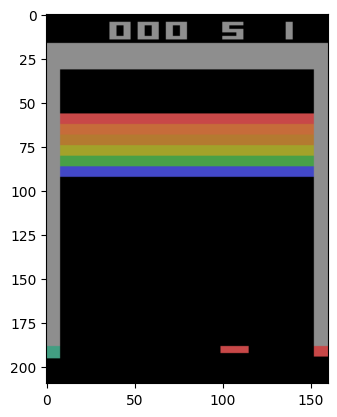

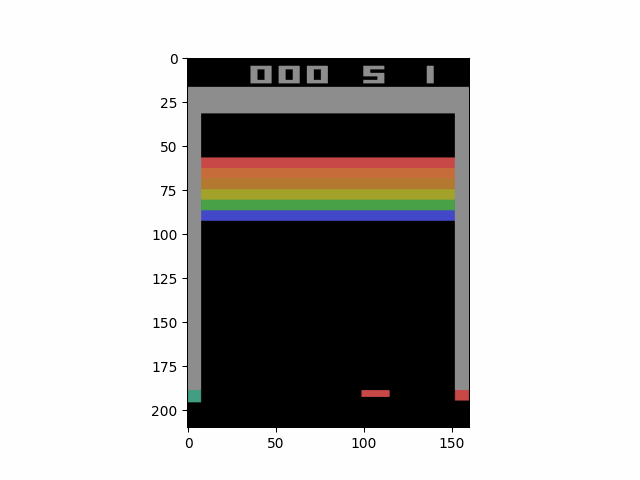

In [ ]:
### Plot some mini-batch at random

print('debug and test results')
if(False):
    print('plot some mini-batch at random')
    minibatch = my_replay_memory.get_minibatch()
    no_frames = my_replay_memory.agent_history_length
    fig = plt.figure(figsize=(MINIBATCH_SIZE*4, no_frames*4))
    for ii in range(no_frames):
        for iii in range(MINIBATCH_SIZE):
            plt.subplot(my_replay_memory.agent_history_length, MINIBATCH_SIZE, iii+ii*MINIBATCH_SIZE+1)
            plt.imshow(minibatch[0][iii, :, :, ii], cmap='jet')  # images are in minibatch[0] stored as minibatch[0].shape=(32, 84, 84, 4) ndarray
            plt.axis('off')
    plt.show()

env_test = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
action_meanings = env_test.unwrapped.get_action_meanings()

if(False):
    print('load model from directory model_bak')
    loaded_model = keras.models.load_model('model_bak')
    agent.model.set_weights(loaded_model.get_weights())

print('play game and draw results')
import matplotlib.animation as animation
images = []  # List to store the generated images

current_frame, _ = env_test.reset()  # single frame 84x84
current_frame_pre = pre_processing(current_frame)
# initialize
current_states = np.zeros(current_frame_pre.shape + (4,))
current_states[:, :, 0] = current_frame_pre.copy()

for jj in range(3):
    new_frame, reward, done1, done2, _ = env_test.step(action)
    current_states[:, :, jj+1] = pre_processing(new_frame)

plt.figure('play')
done = False
count = 0
max_frames_play = 20
while (not done) and (count < max_frames_play):
    count += 1
    current_qs_list = agent.model.predict(current_states[None, ...], verbose=0)  # input_shape=[1,84, 84, 4]
    best_action = np.argmax(current_qs_list)
    print('best action=', action_meanings[best_action], 'frame=', str(count))
    new_current_states = current_states.copy()
    new_current_states[:, :, :-1] = current_states[:, :, 1:]  # shift old states down a unit, put new one after
    new_frame, reward, done1, done2, _ = env_test.step(best_action)
    new_current_states[:, :, -1] = pre_processing(new_frame)
    done = done1 | done2
    images.append(new_frame)
    if(done):
        break
#  plt.imshow(new_frame)
#  plt.savefig("play_"+str(count)+".jpg")
#  plt.pause(0.1)

print('make animation')
fig, ax = plt.subplots()
# Function to update the plot for each frame of the animation
def update(frame):
    ax.imshow(images[frame])  # Display the corresponding image for the current frame

ani = animation.FuncAnimation(fig, update, frames=len(images), interval=400)
ani.save('animation.gif', writer='pillow')  # Requires pillow to be installed
plt.show()

from IPython.display import Image as Image_Ip
from IPython.display import display
display(Image_Ip(filename='animation.gif'))
#if('ipykernel' in sys.modules):#we are in Jupyter Notebook
#if('google.colab' in sys.modules):#we are in google colab